# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

# Project Objective

I aim to construct and compare two investment portfolios using historical stock data from 2015 to 2025:

- A **high-risk portfolio** that aims to maximize returns relative to risk (Sharpe ratio)
- A **low-risk portfolio** that minimizes volatility

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import datetime as dt
from itertools import product
from scipy.stats import normaltest
import os
from scipy.optimize import minimize


sns.set_style('darkgrid')
np.random.seed(1205)

In [15]:
from curl_cffi import requests
import yfinance as yf

session = requests.Session(impersonate="chrome")
ticker = yf.Ticker("AAPL", session=session)
data = ticker.history(start="2015-01-01", end="2025-01-01")


In [11]:
tickers = ['JNJ', 'PG', 'KO', 'PEP', 'D', 'TSLA', 'NVDA', 'PLTR', 'RIVN', 'WMT', 'JPM', 'AAPL']

start_date = '2015-01-01'
end_date = '2025-01-01'

# Download adjusted closing prices
def download_price_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    full_data = data.dropna(axis=1)  # Drop tickers with missing data
    return full_data

prices = download_price_data(tickers, start_date, end_date)

def compute_log_returns(price_df):
    return np.log(price_df / price_df.shift(1)).dropna()

log_returns = compute_log_returns(prices)

[*********************100%***********************]  12 of 12 completed


In [128]:
prices.to_csv("prices.csv")
log_returns.to_csv("log_returns.csv")


In [14]:
prices.head()

Ticker,AAPL,D,JNJ,JPM,KO,NVDA,PEP,PG,TSLA,WMT
Date,,,,,,,,,,
2015-01-02,24.288580,49.614662,78.012604,47.174263,30.222610,0.483066,69.219131,67.441566,14.620667,23.320910
2015-01-05,23.604336,49.012806,77.467743,45.709740,30.222610,0.474906,68.698723,67.120941,14.006000,23.253035
2015-01-06,23.606558,48.763073,77.087097,44.524529,30.452120,0.460508,68.178345,66.815163,14.085333,23.432222
2015-01-07,23.937571,48.961567,78.788864,44.592464,30.832239,0.459308,70.171951,67.165665,14.063333,24.053925
2015-01-08,24.857302,49.537819,79.408363,45.588947,31.205170,0.476586,71.447266,67.933739,14.041333,24.561615


### Visualizing Stock Performance

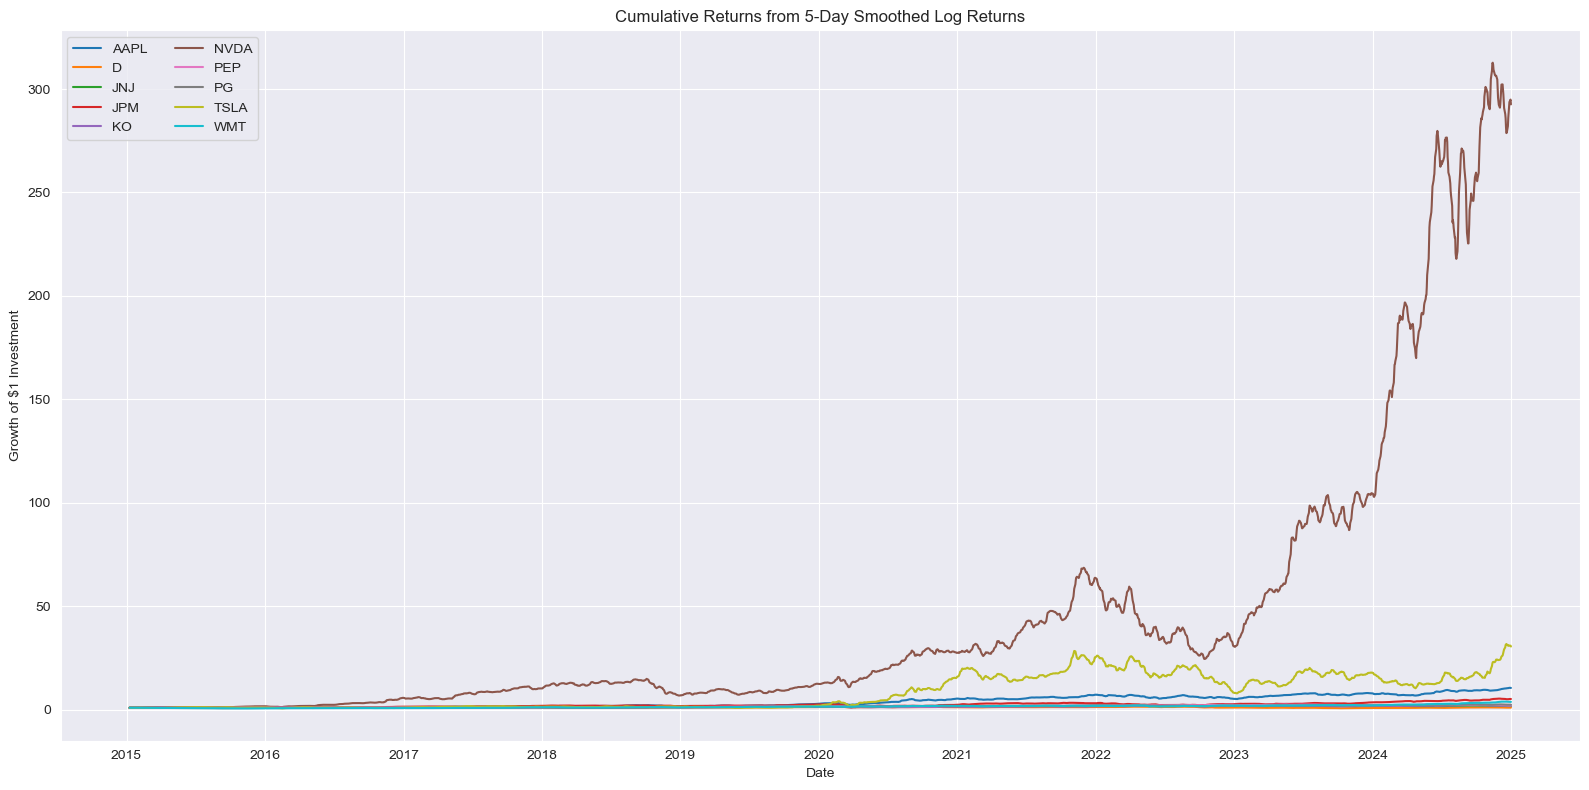

In [44]:
def plot_smoothed_cumulative_returns(log_returns, window=5): #To reduce short-term noise
    rolling_log_returns = log_returns.rolling(window=window).mean()

    cumulative_smoothed_returns = np.exp(rolling_log_returns.cumsum())

    plt.figure(figsize=(16, 8))
    for ticker in cumulative_smoothed_returns.columns:
        plt.plot(cumulative_smoothed_returns.index, cumulative_smoothed_returns[ticker], label=ticker)

    plt.title(f"Cumulative Returns from {window}-Day Smoothed Log Returns")
    plt.xlabel("Date")
    plt.ylabel("Growth of $1 Investment")
    plt.legend(ncol=2, loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Use the function
plot_smoothed_cumulative_returns(log_returns, window=5)


In [131]:
def compute_annualized_metrics(log_returns):
    mean_returns = log_returns.mean() * 252
    volatilities = log_returns.std() * np.sqrt(252) #to assess individual stock risk
    return mean_returns, volatilities

def plot_risk_return(mean_returns, volatilities):
    plt.figure(figsize=(10, 5))
    plt.scatter(volatilities, mean_returns)
    for i, ticker in enumerate(mean_returns.index):
        plt.annotate(ticker, (volatilities[i], mean_returns[i]))
    plt.xlabel('Annualized Volatility (Risk)')
    plt.ylabel('Annualized Mean Return')
    plt.title('Risk vs Return for Individual Stocks')
    plt.grid(True)
    plt.show()

#to understand co-movements among stocks
def plot_correlation_heatmap(log_returns):
    corr_matrix = log_returns.corr()
    plt.figure(figsize=(15, 7))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Matrix of Stock Returns", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_sorted_volatility(volatilities):
    volatilities.sort_values(ascending=False).plot(
        kind='bar', figsize=(10, 5), title='Annualized Volatility'
    )
    plt.ylabel('Volatility')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


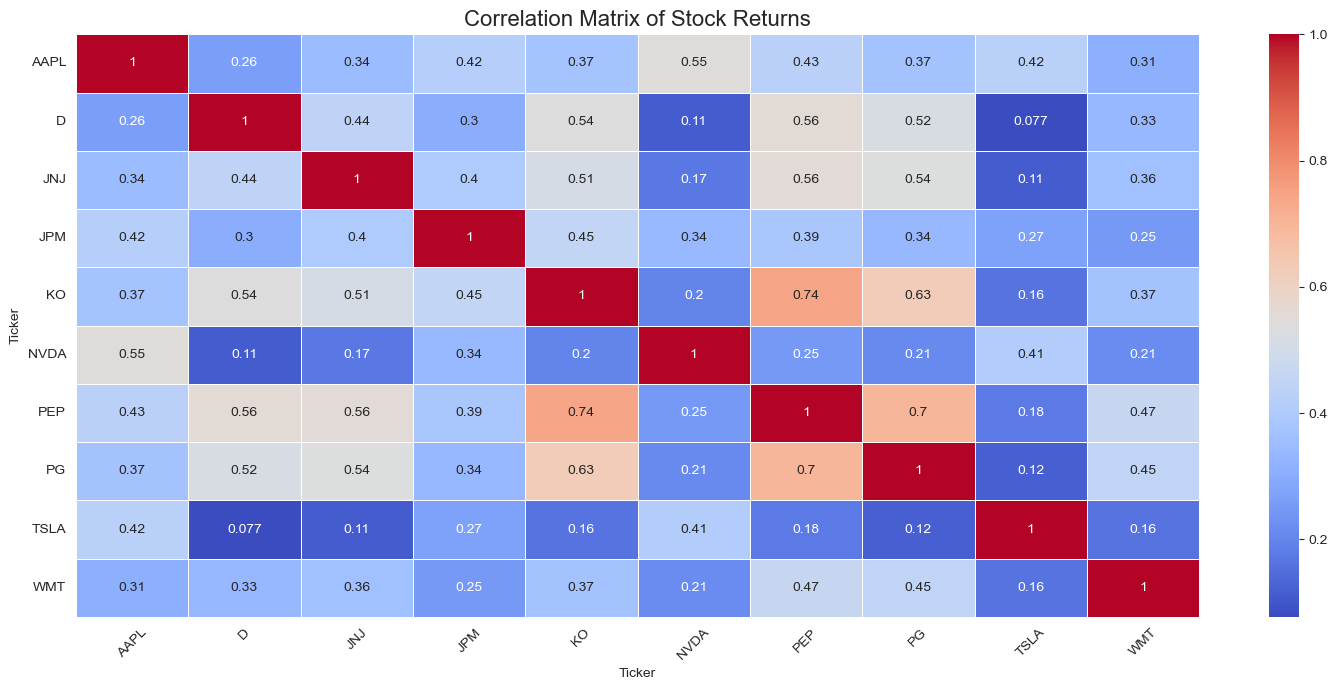

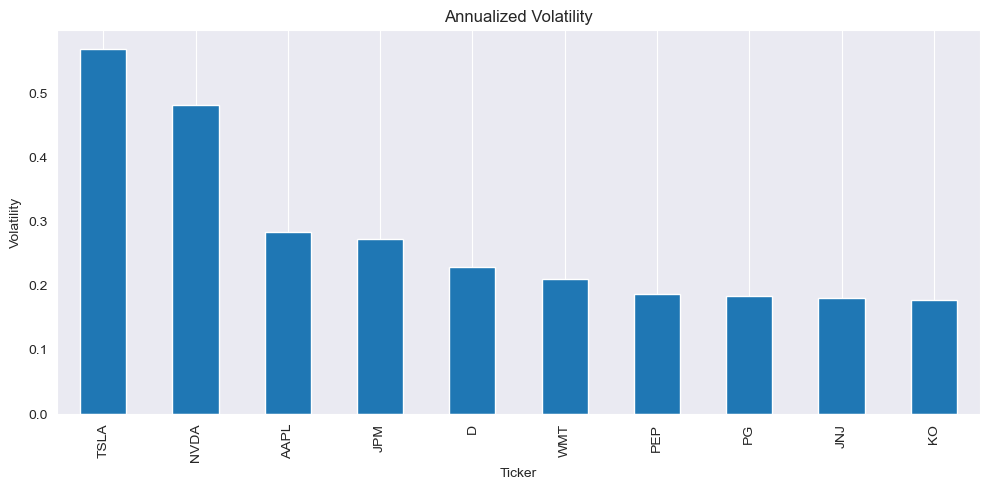

/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_50967/3312665519.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(ticker, (volatilities[i], mean_returns[i]))


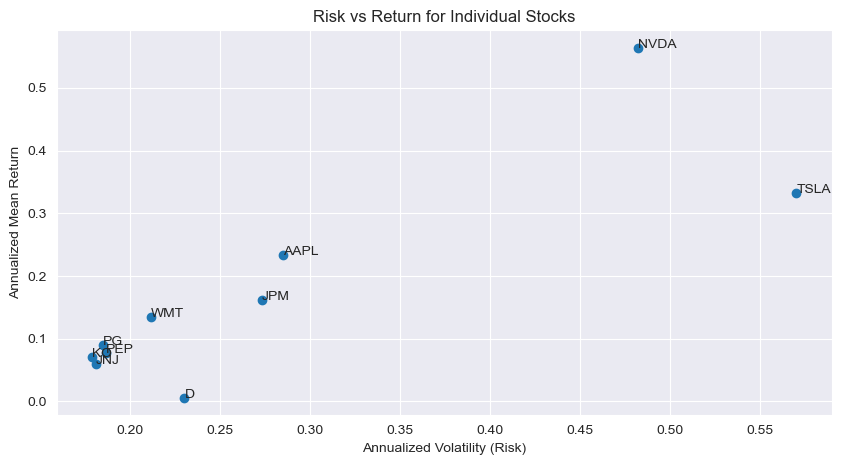

In [132]:
# Compute metrics
annual_returns, annual_volatility = compute_annualized_metrics(log_returns)

# Plot heatmap
plot_correlation_heatmap(log_returns)

# Plot sorted volatility
plot_sorted_volatility(annual_volatility)
plot_risk_return(annual_returns, annual_volatility)


### Portfolio Optimization Strategy

- The **high-risk portfolio** maximizes the Sharpe ratio (return per unit risk)
- The **low-risk portfolio** minimizes portfolio volatility

**Constraints:** no shorting, and total weights = 1

In [37]:
mean_returns, _ = compute_annualized_metrics(log_returns)
cov_matrix = log_returns.cov() * 252
num_assets = len(mean_returns)


The expected return of a portfolio is given by: $R_p = \sum_i w_i \mu_i$

where:
- $R_p $ is the expected portfolio return  
- $w_i$ is the weight of asset $i $  
- $\mu_i$ is the expected return of asset $ i $

The portfolio volatility is: $\sigma_p = \sqrt{\vec{w}^\top \Sigma \vec{w}}$

where:
- $ \sigma_p $ is the portfolio volatility  
- $ \vec{w} $ is the vector of asset weights  
- $ \Sigma $ is the covariance matrix of asset returns

The Sharpe ratio is a measure of return per unit of risk: $\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$

Here, the risk-free rate $( R_f = 0 )$ is assumed, so: $\text{Sharpe Ratio} = \frac{R_p}{\sigma_p}$

where:
- $ R_p $ is the expected portfolio return  
- $ \sigma_p $ is the portfolio volatility  
- $ R_f $ is the risk-free rate


In [38]:
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    ret = portfolio_return(weights, mean_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return -ret / vol  # Negated for maximization

def portfolio_variance(weights, cov_matrix):
    return portfolio_volatility(weights, cov_matrix)**2


In [99]:
# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights between 0 and 1
bounds_high = tuple((0, 0.80) for _ in range(num_assets)) #weights between 0 and 0.8 for high risk
bounds_low = tuple((0.05, 0.35) for _ in range(num_assets)) #weights between 0.05 and 0.35 for low risk


# Initial guess: equal weights
init_guess = num_assets * [1. / num_assets]


In [100]:
# Max Sharpe (High Risk)
opt_sharpe = minimize(
    negative_sharpe_ratio, init_guess,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds_high,
    constraints=constraints
)

# Min Volatility (Low Risk)
opt_vol = minimize(
    portfolio_variance, init_guess,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds_low,
    constraints=constraints
)


In [101]:
tickers = log_returns.columns
high_risk_portfolio = dict(zip(tickers, opt_sharpe.x))
low_risk_portfolio = dict(zip(tickers, opt_vol.x))


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_50967/521829382.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


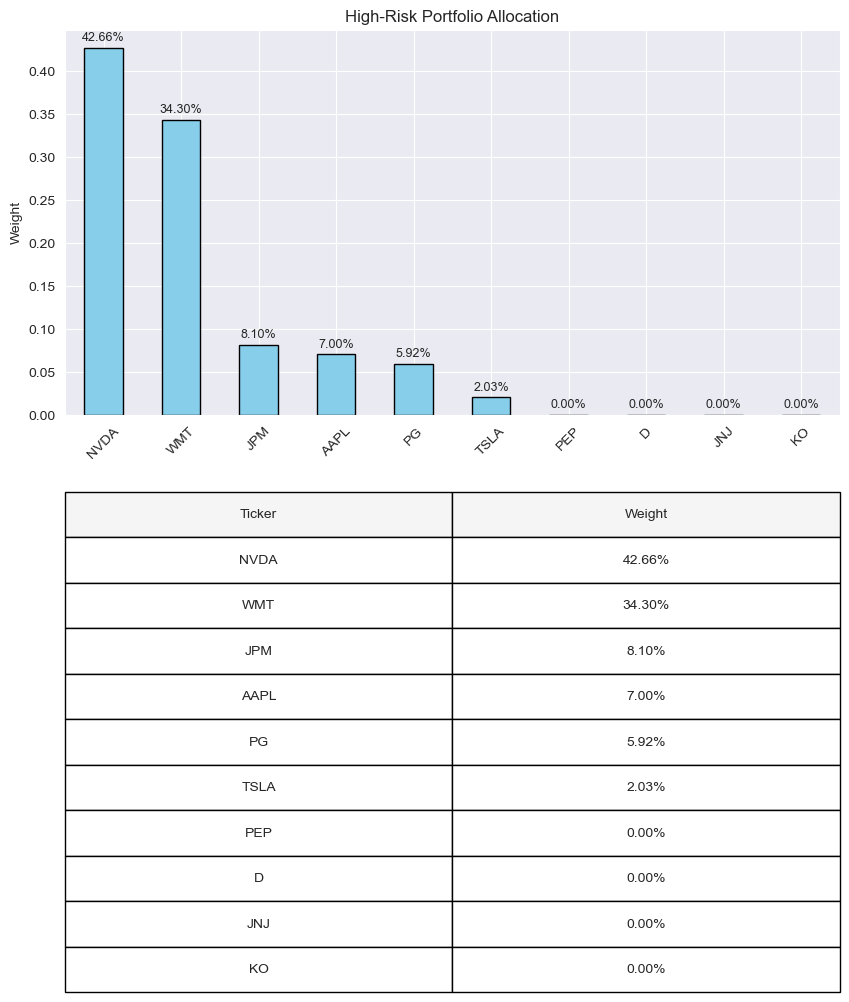

/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_50967/521829382.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


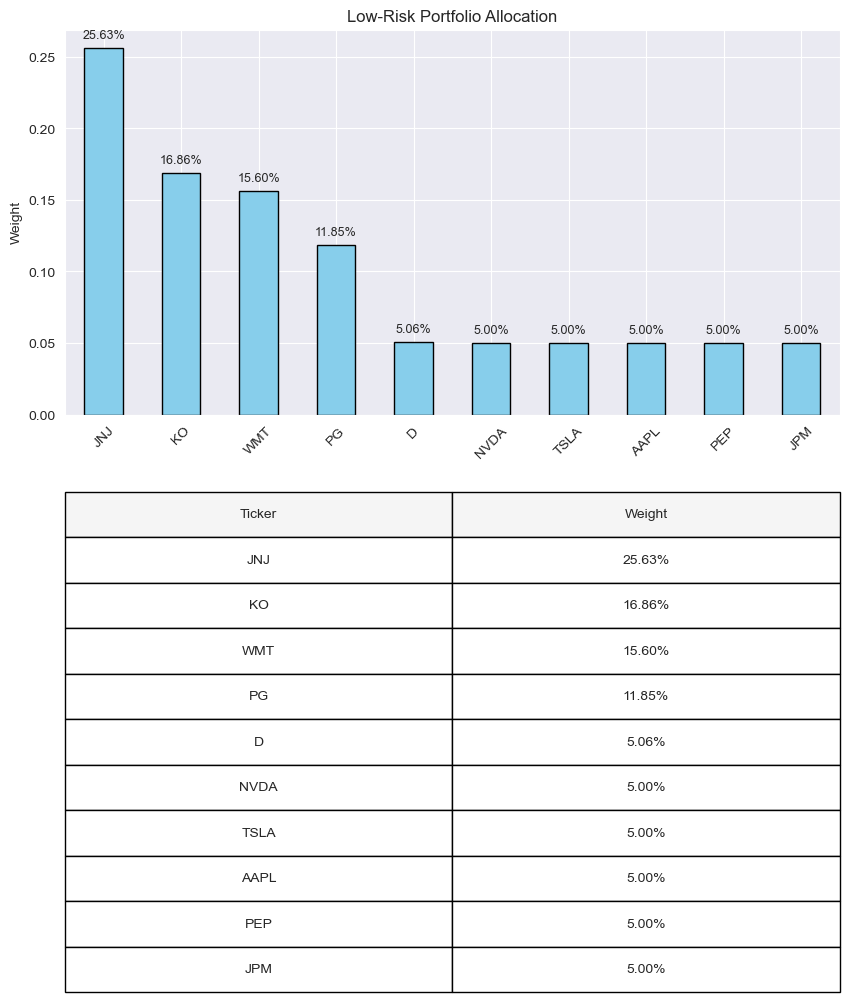

In [126]:
def plot_portfolio_allocation_with_table(weights_dict, title):
    series = pd.Series(weights_dict).sort_values(ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = series.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    
    for i, (stock, weight) in enumerate(series.items()):
        ax.text(i, weight + 0.005, f"{weight:.2%}", ha='center', va='bottom', fontsize=9)
    
    ax.set_title(title)
    ax.set_ylabel("Weight")
    ax.set_xticklabels(series.index, rotation=45)
    ax.grid(True, axis='y')

    table_data = [[ticker, f"{w:.2%}"] for ticker, w in series.items()]
    table = plt.table(cellText=table_data,
                      colLabels=["Ticker", "Weight"],
                      cellLoc='center',
                      colColours=["#f5f5f5"]*2,
                      bbox=[0.0, -1.5, 1, 1.3])  # [left, bottom, width, height]
    
    plt.tight_layout()
    plt.show()

plot_portfolio_allocation_with_table(high_risk_portfolio, "High-Risk Portfolio Allocation")
plot_portfolio_allocation_with_table(low_risk_portfolio, "Low-Risk Portfolio Allocation")


In [127]:
def print_portfolio_stats(portfolio, log_returns, label):
    weights = np.array(list(portfolio.values()))
    mean_returns, _ = compute_annualized_metrics(log_returns)
    cov_matrix = log_returns.cov() * 252

    expected_return = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = expected_return / volatility

    print(f"\n{label} Portfolio:")
    print(f"Expected Return: {expected_return:.2%}")
    print(f"Volatility     : {volatility:.2%}")
    print(f"Sharpe Ratio   : {sharpe_ratio:.2f}")

print_portfolio_stats(high_risk_portfolio, log_returns, "High-Risk")
print_portfolio_stats(low_risk_portfolio, log_returns, "Low-Risk")



High-Risk Portfolio:
Expected Return: 32.84%
Volatility     : 26.32%
Sharpe Ratio   : 1.25

Low-Risk Portfolio:
Expected Return: 12.79%
Volatility     : 15.12%
Sharpe Ratio   : 0.85


In [129]:
pd.Series(high_risk_portfolio).sort_index().to_csv("high_risk_portfolio_weights.csv", header=["Weight"])


In [130]:
pd.Series(low_risk_portfolio).sort_index().to_csv("low_risk_portfolio_weights.csv", header=["Weight"])
